In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings('ignore')
import statsmodels

In [25]:
data = pd.read_csv("lung_cancer_prediction_dataset.csv")
df = data.copy()

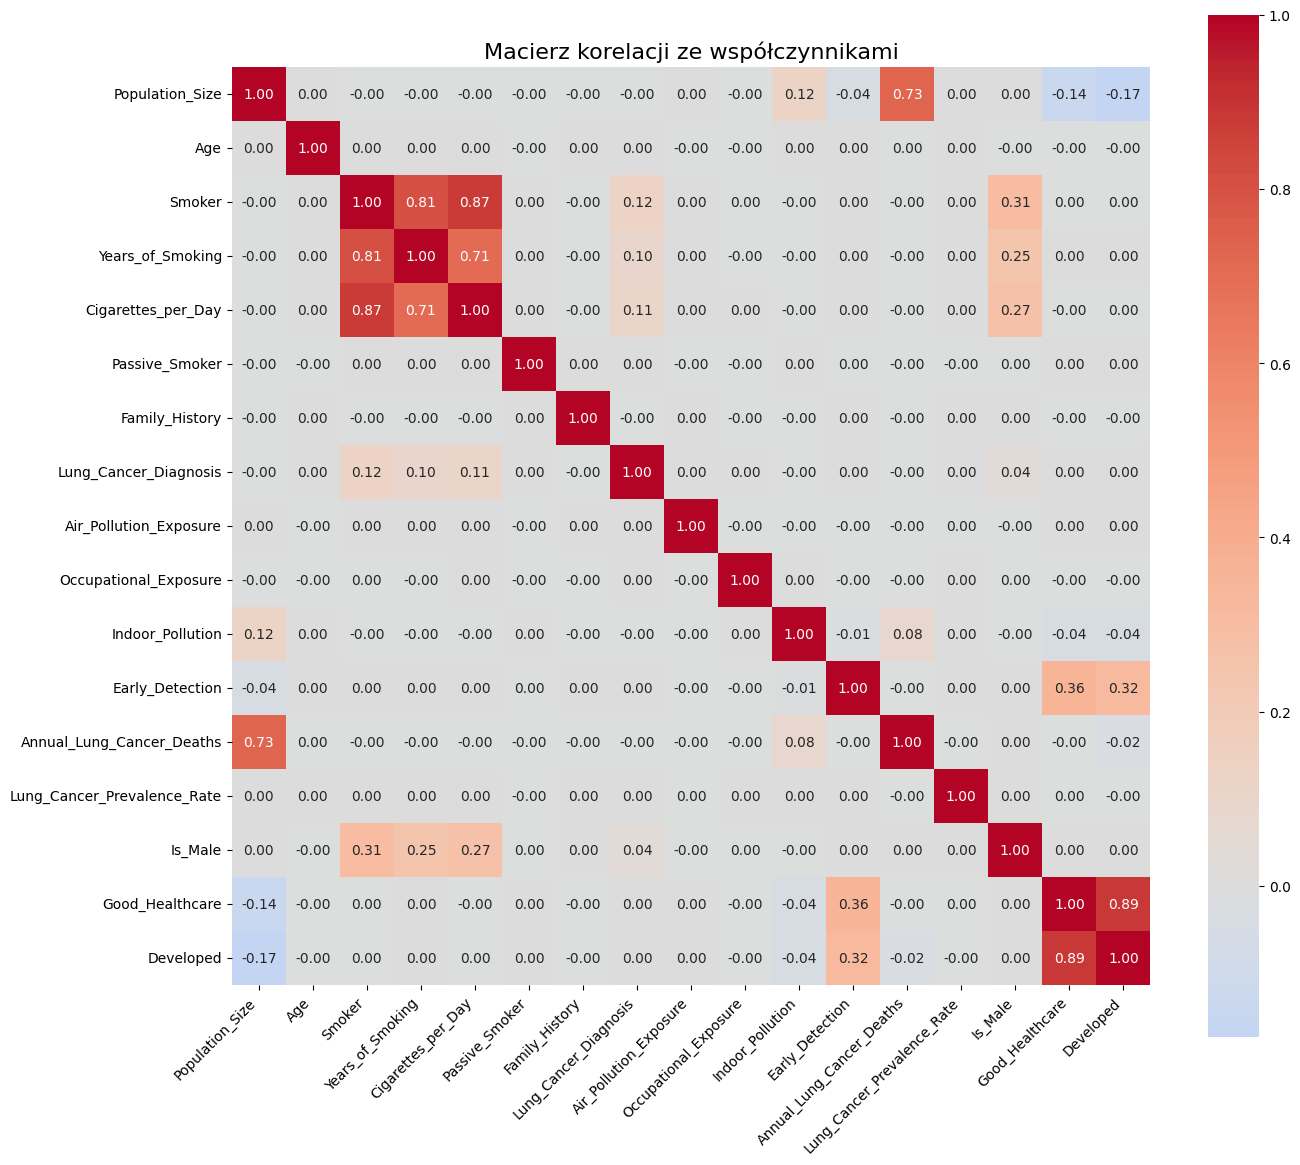

In [28]:
#Korelacja zmiennych
df["Is_Male"] = (df["Gender"] == "Male").astype(int)
df["Good_Healthcare"] = (df["Healthcare_Access"] == "Good").astype(int)
df["Developed"] = (df["Developed_or_Developing"]
                     == "Developed").astype(int)

df = df.replace({"Yes": 1, "No": 0, "Low": 0, "Medium": 1, "High": 2})

df = df.drop(columns=["Developed_or_Developing", "Healthcare_Access", "Gender", "ID"
                          ,"Country", "Cancer_Stage", "Treatment_Type", "Mortality_Rate", "Survival_Years", "Adenocarcinoma_Type"])

plt.figure(figsize=(14, 12)) 
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Macierz korelacji ze współczynnikami", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)               
plt.tight_layout()
plt.show()

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Wybór zmiennych do sprawdzenia współliniowości
X = df[["Smoker", "Cigarettes_per_Day", "Years_of_Smoking"]]

# Obliczenie VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature       VIF
0              Smoker  9.553342
1  Cigarettes_per_Day  6.439387
2    Years_of_Smoking  4.142995


In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Wybór zmiennych do sprawdzenia współliniowości
X = df[["Good_Healthcare","Developed"]]

# Obliczenie VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

           Feature       VIF
0  Good_Healthcare  6.008975
1        Developed  6.008975


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Wybór zmiennych do sprawdzenia współliniowości
X = df[["Population_Size","Annual_Lung_Cancer_Deaths"]]

# Obliczenie VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                     Feature       VIF
0            Population_Size  2.658751
1  Annual_Lung_Cancer_Deaths  2.658751


In [11]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(columns=["Lung_Cancer_Diagnosis", 'Smoker'])  
y = df["Lung_Cancer_Diagnosis"]

selector = SelectKBest(score_func=f_classif, k=5) 
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"Najlepsze cechy: {selected_features.tolist()}")

Najlepsze cechy: ['Population_Size', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Occupational_Exposure', 'Is_Male']


In [12]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)  
lasso.fit(X, y)

selected_features = X.columns[lasso.coef_ != 0]
print(f"Najważniejsze cechy wg LASSO: {selected_features.tolist()}")

Najważniejsze cechy wg LASSO: ['Population_Size', 'Years_of_Smoking', 'Cigarettes_per_Day', 'Annual_Lung_Cancer_Deaths']


In [20]:
y = df["Lung_Cancer_Diagnosis"]

X = df.drop(columns=["Lung_Cancer_Diagnosis"])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

rfe = RFE(estimator=model, n_features_to_select=8)

rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
ranking = rfe.ranking_

print("Wybrane cechy:", list(selected_features))
print("Ranking wszystkich cech:")
for name, rank in zip(X.columns, ranking):
    print(f"{name}: {rank}")


Wybrane cechy: ['Smoker', 'Passive_Smoker', 'Family_History', 'Occupational_Exposure', 'Indoor_Pollution', 'Early_Detection', 'Is_Male', 'Good_Healthcare']
Ranking wszystkich cech:
Population_Size: 7
Age: 5
Smoker: 1
Years_of_Smoking: 6
Cigarettes_per_Day: 8
Passive_Smoker: 1
Family_History: 1
Air_Pollution_Exposure: 4
Occupational_Exposure: 1
Indoor_Pollution: 1
Early_Detection: 1
Annual_Lung_Cancer_Deaths: 9
Lung_Cancer_Prevalence_Rate: 3
Is_Male: 1
Good_Healthcare: 1
Developed: 2


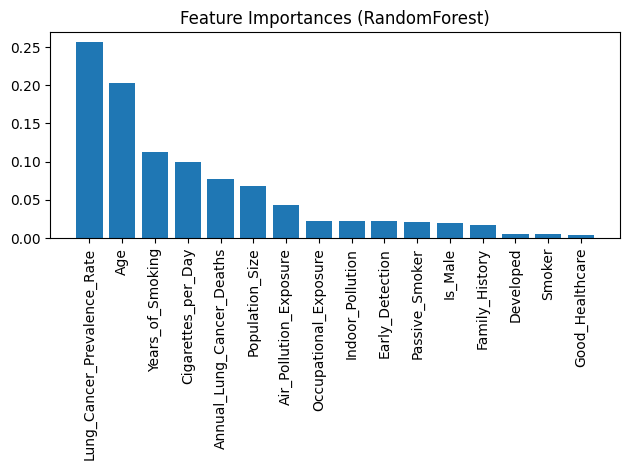

In [95]:
from sklearn.ensemble import RandomForestClassifier   
from sklearn.model_selection import train_test_split

X = df.drop('Lung_Cancer_Diagnosis', axis=1)
y = df['Lung_Cancer_Diagnosis']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_ 
feature_names = X.columns      

indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.title('Feature Importances (RandomForest)')
plt.tight_layout() 
plt.show()

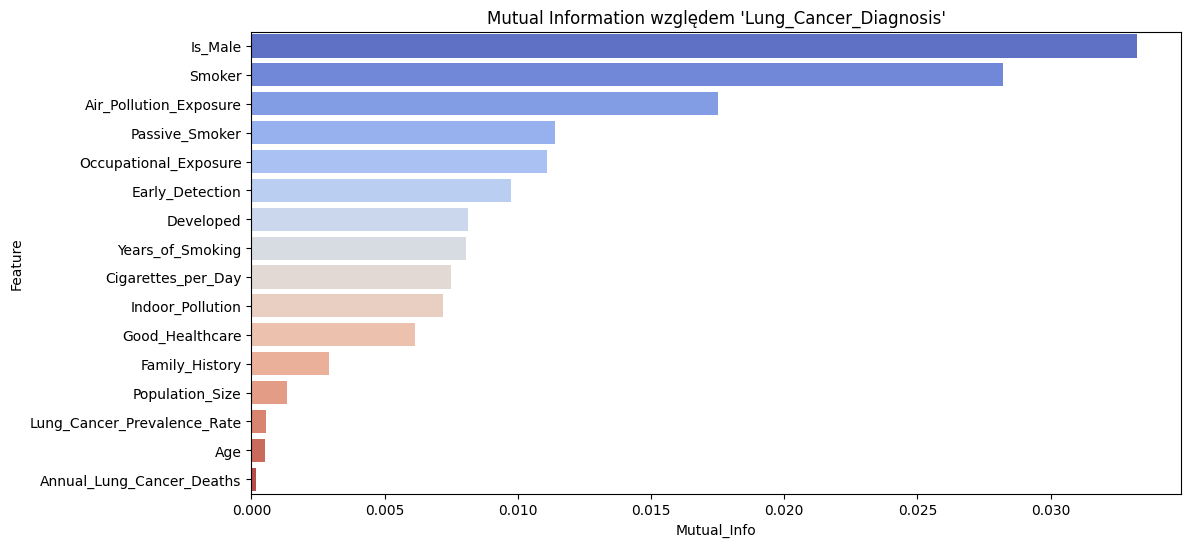

In [96]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop(columns=["Lung_Cancer_Diagnosis"])
y = df["Lung_Cancer_Diagnosis"]

mi_scores = mutual_info_classif(X, y, discrete_features='auto')

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mi_scores})
mi_df = mi_df.sort_values(by='Mutual_Info', ascending=False)

# Wykres słupkowy
plt.figure(figsize=(12, 6))
sns.barplot(data=mi_df, x='Mutual_Info', y='Feature', palette='coolwarm')
plt.title("Mutual Information względem 'Lung_Cancer_Diagnosis'")
plt.show()

0         870
1           0
2          72
3           0
4           0
         ... 
220627     40
220628      0
220629      0
220630      0
220631      0
Name: Smoking_Exposure, Length: 220632, dtype: int64


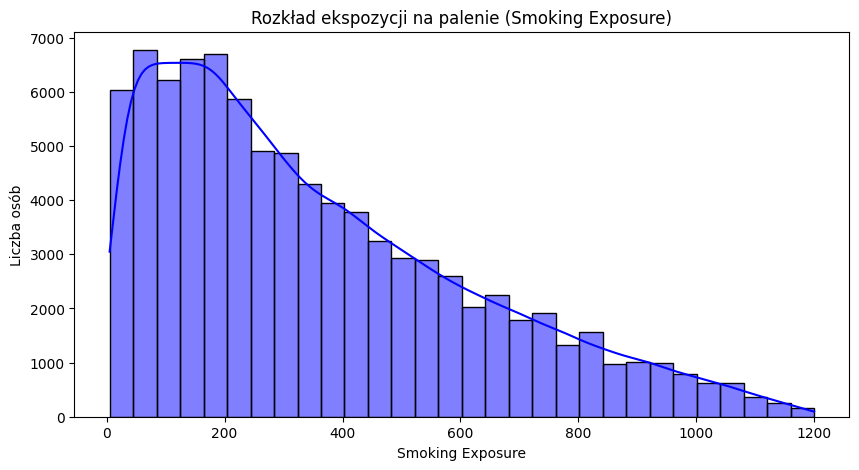

In [21]:
df["Smoking_Exposure"] = df["Cigarettes_per_Day"] * df["Years_of_Smoking"] 
print(df["Smoking_Exposure"])
df1 = df[df["Smoking_Exposure"] > 0]
plt.figure(figsize=(10, 5))
sns.histplot(df1["Smoking_Exposure"], bins=30, kde=True, color="blue")

plt.title("Rozkład ekspozycji na palenie (Smoking Exposure)")
plt.xlabel("Smoking Exposure")
plt.ylabel("Liczba osób")
plt.show()

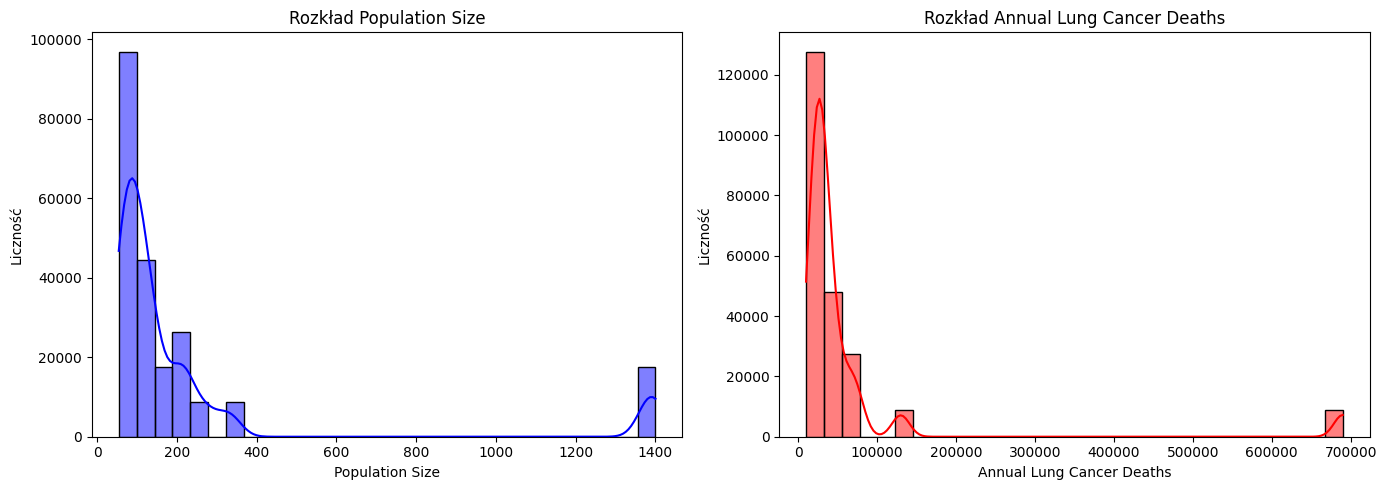

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

# Histogram dla population_size
sns.histplot(df["Population_Size"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Rozkład Population Size")
axes[0].set_xlabel("Population Size")
axes[0].set_ylabel("Liczność")

# Histogram dla annual_lung_cancer_deaths
sns.histplot(df["Annual_Lung_Cancer_Deaths"], bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Rozkład Annual Lung Cancer Deaths")
axes[1].set_xlabel("Annual Lung Cancer Deaths")
axes[1].set_ylabel("Liczność")

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()

In [22]:
df["Healthcare_index"]=df[["Developed","Good_Healthcare"]].sum(axis=1)

df = df.drop(columns=["Smoker", "Years_of_Smoking", "Cigarettes_per_Day",
                      "Developed", "Good_Healthcare","Population_Size"])

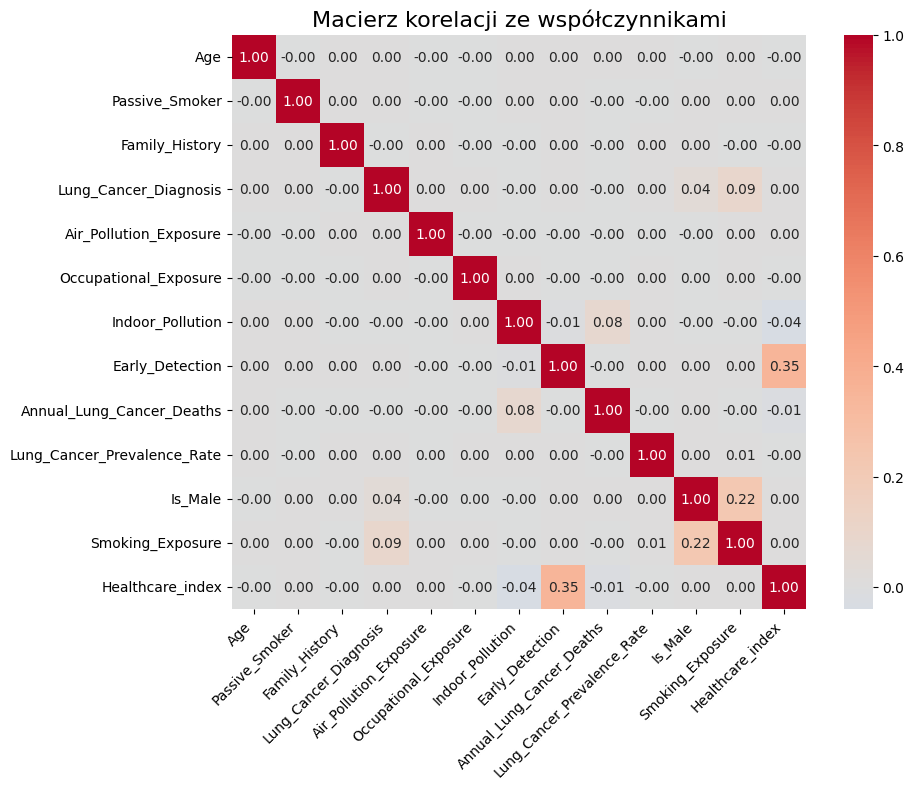

In [23]:
plt.figure(figsize=(10, 8))  
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Macierz korelacji ze współczynnikami", fontsize=16)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)             
plt.tight_layout()
plt.show()

In [106]:
df

,Population_Size,Age,Passive_Smoker,Family_History,Lung_Cancer_Diagnosis,Air_Pollution_Exposure,Occupational_Exposure,Indoor_Pollution,Early_Detection,Annual_Lung_Cancer_Deaths,Lung_Cancer_Prevalence_Rate,Is_Male,Smoking_Exposure,Healthcare_index
0,1400,80,0,0,0,0,1,0,0,690000,2.44,1,317550,0
1,84,53,1,0,0,0,1,0,0,27000,2.10,1,0,0
2,128,47,1,0,0,1,0,0,1,28000,1.11,1,26280,0
3,273,39,0,1,0,0,0,0,0,40000,0.75,0,0,0
4,59,44,1,0,0,1,1,0,0,15000,2.44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220627,70,55,0,1,0,1,0,0,1,26000,0.70,1,14600,0
220628,59,66,0,0,0,2,0,0,0,15000,0.78,1,0,0
220629,97,46,0,0,0,1,0,0,0,22000,1.16,1,0,0
220630,120,36,1,1,0,2,0,0,0,18000,1.06,1,0,0
